<ipython-input-1-a4a4077102c5>:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.41666666666666663' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self.item_similarity_df.loc[i, j] = numerator / denominator if denominator != 0 else 0
<ipython-input-1-a4a4077102c5>:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6666666666666667' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self.item_similarity_df.loc[i, j] = numerator / denominator if denominator != 0 else 0
<ipython-input-1-a4a4077102c5>:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.31622776601683783' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.


Training complete. Item-item similarity matrix built.


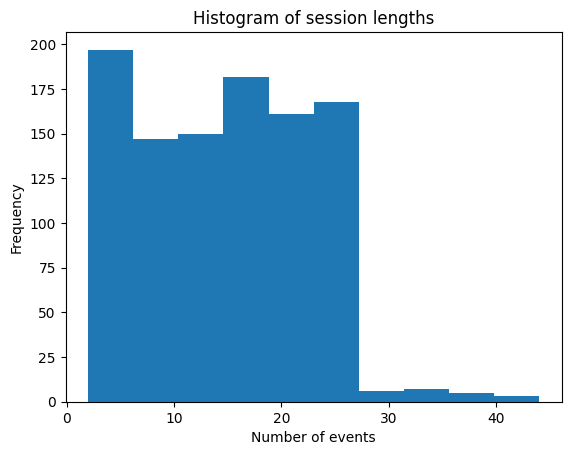

Number of sessions: 1026
Average events per session: 14.688109161793372
Category with highest bounce rate: 18
Country with highest average visit count: Japan
Performer with most visits by category: dance
Session item IDs (converted): [1, 2, 3, 4]
Processing session item: 1
Similar items for session item 1:
item_id
0      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
195    0.0
196    0.0
197    0.0
198    0.0
199    0.0
Name: 1, Length: 199, dtype: float64
Processing session item: 2
Similar items for session item 2:
item_id
0      0.000000
1      0.000000
3      0.000000
4     -0.301511
5     -0.196116
         ...   
195    0.000000
196    0.000000
197   -0.284268
198    0.000000
199    0.000000
Name: 2, Length: 199, dtype: float64
Processing session item: 3
Similar items for session item 3:
item_id
0      0.000000
1      0.000000
2      0.000000
4      0.148522
5      0.226455
         ...   
195    0.000000
196   -0.091287
197    0.152499
198    0.005128
199   -0.287678

In [1]:
#for this code, item based collaborative filtering is done where filtering searches for items (nearest neighbors – NN)
#here similarity is calculated using Pearson correlation coefficient


#below section is recommender.py and the changes are made to it, code is added here, no extra method is added
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

class Recommender:
    def __init__(self, items_path, users_path, events_path):
        #Load data
        self.items = pd.read_csv(items_path)
        self.users = pd.read_csv(users_path)
        self.events = pd.read_csv(events_path)
        self.events['timestamp'] = pd.to_datetime(self.events['timestamp'], unit='s')  # Convert timestamp from Unix time
        self.events = self.events.sort_values(by=['user_id', 'timestamp'])




    #in train here PCC similarity fomula is used to calculate the similarity of the items with the ones in ongoing session
    def train(self):
        # created a user-item matrix (ratings-like interaction matrix)
        user_item_matrix = self.events.pivot_table(index='user_id', columns='item_id', aggfunc='size', fill_value=0)

        # computed item-item similarity using PCC
        self.item_similarity_df = pd.DataFrame(index=user_item_matrix.columns, columns=user_item_matrix.columns, dtype=np.float32)

        for i in self.item_similarity_df.columns:
            for j in self.item_similarity_df.columns:
                if i == j:
                    continue
                # Calculated the similarity between items i and j
                common_users = user_item_matrix[(user_item_matrix[i] > 0) & (user_item_matrix[j] > 0)].index

                if len(common_users) == 0:
                    self.item_similarity_df.loc[i, j] = 0
                    continue

                # Formula for PCC between items i and j
                ratings_i = user_item_matrix.loc[common_users, i] - user_item_matrix.loc[common_users, i].mean()
                ratings_j = user_item_matrix.loc[common_users, j] - user_item_matrix.loc[common_users, j].mean()

                numerator = np.sum(ratings_i * ratings_j)
                denominator = np.sqrt(np.sum(ratings_i ** 2)) * np.sqrt(np.sum(ratings_j ** 2))

                self.item_similarity_df.loc[i, j] = numerator / denominator if denominator != 0 else 0

        print("Training complete. Item-item similarity matrix built.")




    def analyse(self):
          # Step 1: Separate sessions by a gap of >= 8 hours between two events for each user
          self.events['session_gap'] = self.events.groupby('user_id')['timestamp'].diff().dt.total_seconds() >= 8 * 3600
          self.events['session_id'] = self.events.groupby('user_id')['session_gap'].cumsum()
          self.events.drop('session_gap', axis=1, inplace=True)

          # Step 2: Remove duplicate visits of the same item within each session
          self.events = self.events.drop_duplicates(subset=['user_id', 'session_id', 'item_id'])

          # Step 3: Filter out sessions with only a single event
          session_sizes = self.events.groupby(['user_id', 'session_id']).size()
          valid_sessions = session_sizes[session_sizes > 1].index
          self.events = self.events[self.events.set_index(['user_id', 'session_id']).index.isin(valid_sessions)].reset_index(drop=True)

          # Step 4: Calculate statistics
          num_sessions = len(valid_sessions)
          avg_events_per_session = session_sizes[session_sizes > 1].mean()

          # Step 5: Histogram of session lengths for valid sessions (with > 1 event)
          valid_session_sizes = session_sizes[session_sizes > 1]
          plt.hist(valid_session_sizes, bins=10)
          plt.xlabel("Number of events")
          plt.ylabel("Frequency")
          plt.title("Histogram of session lengths")
          plt.show()

          # Step 6: Category with the highest bounce rate (last event in each session)
          last_events = self.events.groupby('session_id').last()
          highest_bounce_category = last_events['item_id'].value_counts().idxmax()

          # Step 7: Country with the highest average visit count per user
          user_country_visits = self.events.groupby('user_id').size().groupby(self.users.set_index('user_id')['country']).mean()
          highest_avg_visit_country = user_country_visits.idxmax()

          # Step 8: Performer with most visits by category (assuming "category" refers to item types in `items`)
          most_visited_performers = self.items.groupby('category')['item_id'].count().idxmax()

          # Output results
          print(f"Number of sessions: {num_sessions}")
          print(f"Average events per session: {avg_events_per_session}")
          print(f"Category with highest bounce rate: {highest_bounce_category}")
          print(f"Country with highest average visit count: {highest_avg_visit_country}")
          print(f"Performer with most visits by category: {most_visited_performers}")



    #Recommend items based on the session's item history using PCC and calculating an accumulative score for each item, each session
    def recommend(self, session_item_ids):
        accumulative_scores = defaultdict(float)
        session_item_ids = [int(item) for item in session_item_ids if item.strip().isdigit()]
        print(f"Session item IDs (converted): {session_item_ids}")

        # Checked similarity for each item in the session
        for session_item in session_item_ids:
            if session_item in self.item_similarity_df.index:
                print(f"Processing session item: {session_item}")
                # Get the items similar to session_item
                similar_items = self.item_similarity_df.loc[session_item].drop(session_item)  # Exclude the item itself
                print(f"Similar items for session item {session_item}:\n{similar_items}")

                for accumulative_item, similarity_score in similar_items.items():
                    accumulative_scores[accumulative_item] += similarity_score

        print(f"\nAccumulative scores (before sorting):\n{accumulative_scores}")

        # Sorted the items by the similarity score
        sorted_accumulative = sorted(accumulative_scores.items(), key=lambda x: x[1], reverse=True)
        recommended_items = [item for item, score in sorted_accumulative if item not in session_item_ids]
        print(f"\nSorted accumulative scores by similarity:\n{sorted_accumulative}")

        # Ensure that 5 items are returned
        recommended_items = recommended_items[:5]
        print(f"\nFinal recommended items for session {session_item_ids}: {recommended_items}")
        return recommended_items



# the below section is a part of evaluation

items_path = './items.csv'
users_path = './users.csv'
events_path = './events.csv'
session_path = './sessions.csv'

# Initialize the Recommender
r = Recommender(items_path, users_path, events_path)

# Train the model
r.train()

# Analyze the dataset
r.analyse()

# Evaluate recommender
with open(session_path, 'r') as f:
    hits = 0
    total = 0
    for row in f.readlines():
        parts = row.split("\t")
        session = parts[0].split(",")
        target_item = row[1]
        recommended = r.recommend(session)
        if target_item in recommended:
            hits +=1
        total+=1
    print("Hits: {}/{}".format(hits, total))

